In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange

import torch
print("PyTorch:", torch.__version__)

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

import torch
print(torch.version.cuda)   # shows the CUDA version PyTorch was built against
print(torch.backends.cudnn.version())  # cuDNN version
print(torch.cuda.is_available())

import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Kernel Python: /work3/s232958/envs/esm_gpu/bin/python
PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts
12.1
90100
True


In [2]:
def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


### Loading PPint data

In [3]:
### Loading df
PPint_interactions = pd.read_csv("../data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz",index_col=0).reset_index(drop=True)

### Creating dictionary : PDB_interface_name : {"seq_target" : target sequence, "seq_binder" : binder sequence,}
PPint_interactions_dict = {}

for idx, row in PPint_interactions.iterrows():
    pdb_inter_name = row["PDB_interface_name"]
    seq = row["sequence"]
    
    if pdb_inter_name not in PPint_interactions_dict:
        PPint_interactions_dict[pdb_inter_name] = {
            "seq_target": seq,
            "seq_binder": "placeholder"}
    else:
        PPint_interactions_dict[pdb_inter_name]["seq_binder"] = seq

### Cnver dictionary to Dataframe
PPint_interactions_df_NEW = pd.DataFrame([{"target_id": inter_name, "seq_target": vals["seq_target"], "seq_binder": vals["seq_binder"]} for inter_name, vals in PPint_interactions_dict.items() ])
PPint_interactions_df_NEW

### Create dictionary for unique target/ binder sequence
target_seq_to_id = {}
binder_seq_to_id = {}

# Iterate through rows
for _, row in PPint_interactions_df_NEW.iterrows():
    seq_t = row["seq_target"]
    seq_b = row["seq_binder"]
    tid = row["target_id"]

    # For target sequence
    if seq_t not in target_seq_to_id:
        target_seq_to_id[seq_t] = tid

    # For binder sequence
    if seq_b not in binder_seq_to_id:
        binder_seq_to_id[seq_b] = tid

### Assign new ids based in the unique sequences of targets/binder, so that the same sequences would be assigned the same id (both for binders and targets)
PPint_interactions_df_NEW["target_seq_to_id"] = PPint_interactions_df_NEW["seq_target"].map(target_seq_to_id)
PPint_interactions_df_NEW["binder_seq_to_id"] = PPint_interactions_df_NEW["seq_binder"].map(binder_seq_to_id)


### Renaming some columns
PPint_interactions_df_NEW["target_binder_id"] = PPint_interactions_df_NEW["target_seq_to_id"] + "_" + PPint_interactions_df_NEW["binder_seq_to_id"]
PPint_interactions_df_NEW = PPint_interactions_df_NEW.drop(columns = ["target_id"]).rename(columns = {
    "target_seq_to_id" : "target_id",
    "binder_seq_to_id" : "binder_id"})

# ### take random sample of binders for encoding (10%)
# PPint_interactions_df_NEW_sample = PPint_interactions_df_NEW.sample(n=int(len(PPint_interactions_df_NEW) * 0.1), random_state=0) #sampling 10% of datapoints
# PPint_interactions_df_NEW_sample

PPint_interactions_df_NEW

,seq_target,seq_binder,target_id,binder_id,target_binder_id
0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,TVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIHAL...,6NZA_0,6NZA_0,6NZA_0_6NZA_0
1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1,9JKA_1,9JKA_1_9JKA_1
2,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1,8DQ6_1,8DQ6_1_8DQ6_1
3,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0,2YMZ_0,2YMZ_0_2YMZ_0
4,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,6IDB_0,6IDB_0,6IDB_0_6IDB_0
...,...,...,...,...,...
24720,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,6O42_0,6O42_0,6O42_0_6O42_0
24721,GVEERRQQLIGVALDLFSRRSPDEVSIDEIASAAGISRPLVYHYFP...,RRQQLIGVALDLFSRRSPDEVSIDEIASAAGISRPLVYHYFPGKLS...,2QIB_0,2QIB_0,2QIB_0_2QIB_0
24722,MKVGQDKVVTIRYTLQVEGEVLDQGELSYLHGHRNLIPGLEEALEG...,TRYWNAKALPFAFG,7OXG_0,7OXG_0,7OXG_0_7OXG_0
24723,EIVLTQSPVTLSLSSGETGTLSCRASQNISSSWIAWYQQRRGQVPR...,QVQLVQSGAEVRKPGSSVTISCKPVGGTFTNFAIHWVRQAPGQGLE...,6UUM_0,6UUM_0,6UUM_0_6UUM_0


In [5]:
# 1. Build the "target rows"
df_target = pd.DataFrame({
    "id":      "target_" + PPint_interactions_df_NEW["target_id"].astype(str),
    "sequence": PPint_interactions_df_NEW["seq_target"].astype(str),
    "pair_id": PPint_interactions_df_NEW["target_binder_id"].astype(str),  # optional: keep the original pair mapping
    "role":    "target",                            # optional: explicit role column
})

# 2. Build the "binder rows"
df_binder = pd.DataFrame({
    "id":      "binder_" + PPint_interactions_df_NEW["binder_id"].astype(str),
    "sequence": PPint_interactions_df_NEW["seq_binder"].astype(str),
    "pair_id": PPint_interactions_df_NEW["target_binder_id"].astype(str),
    "role":    "binder",
})

# 3. Stack them (row-wise)
PPint_interactions_df_long = pd.concat([df_target, df_binder], ignore_index=True)

# 4. (optional but nice) drop duplicates in case target==binder in homodimers etc.
# PPint_interactions_df_long = PPint_interactions_df_long.drop_duplicates(subset=["id", "sequence"]).reset_index(drop=True)

PPint_interactions_df_long

,id,sequence,pair_id,role
0,target_6NZA_0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,6NZA_0_6NZA_0,target
1,target_9JKA_1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1_9JKA_1,target
2,target_8DQ6_1,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1_8DQ6_1,target
3,target_2YMZ_0,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0_2YMZ_0,target
4,target_6IDB_0,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,6IDB_0_6IDB_0,target
...,...,...,...,...
49445,binder_6O42_0,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,6O42_0_6O42_0,binder
49446,binder_2QIB_0,RRQQLIGVALDLFSRRSPDEVSIDEIASAAGISRPLVYHYFPGKLS...,2QIB_0_2QIB_0,binder
49447,binder_7OXG_0,TRYWNAKALPFAFG,7OXG_0_7OXG_0,binder
49448,binder_6UUM_0,QVQLVQSGAEVRKPGSSVTISCKPVGGTFTNFAIHWVRQAPGQGLE...,6UUM_0_6UUM_0,binder


In [7]:
PPint_interactions_df_NEW_sample.to_csv("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/PPint_interactions.csv", index = False)

### Loading ESM2

In [9]:
# model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t48_15B_UR50D")
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
model.eval().to("cuda")
batch_converter = alphabet.get_batch_converter()

model

Using cache found in /work3/s232958/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

### Encoding PPint_DB

In [12]:
path_to_output_embeddings_targets = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/targets_embeddings_esm2"
path_to_output_embeddings_binders = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/binders_embeddings_esm2"

os.makedirs(path_to_output_embeddings_targets, exist_ok=True)
os.makedirs(path_to_output_embeddings_binders, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

seen_targets = set()
seen_binders = set()

for i in trange(len(PPint_interactions_df_NEW_sample), desc="Embedding"):
    # ---- target ----
    seq_target = PPint_interactions_df_NEW_sample.iloc[i]["seq_target"]
    target_id  = PPint_interactions_df_NEW_sample.iloc[i]["target_id"]

    if target_id not in seen_targets:
        data = [(target_id, seq_target)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            L = model.num_layers
            reps = model(
                batch_tokens.to("cuda"),
                repr_layers=[L],
                return_contacts=False
            )["representations"][L]  # shape: [1, seq_len, hidden_dim]

        emb_np = to_numpy(reps[0, :batch_lens[0]])  # trim padding for cleanliness

        out_path = os.path.join(
            path_to_output_embeddings_targets,
            f"t_{target_id}.npy"
        )
        np.save(out_path, emb_np)
        seen_targets.add(target_id)

    # ---- binder ----
    seq_binder = PPint_interactions_df_NEW_sample.iloc[i]["seq_binder"]
    binder_id  = PPint_interactions_df_NEW_sample.iloc[i]["binder_id"]

    if binder_id not in seen_binders:
        data = [(binder_id, seq_binder)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            L = model.num_layers
            reps = model(
                batch_tokens.to("cuda"),
                repr_layers=[L],
                return_contacts=False
            )["representations"][L]

        emb_np = to_numpy(reps[0, :batch_lens[0]])

        out_path = os.path.join(
            path_to_output_embeddings_binders,
            f"b_{binder_id}.npy"
        )
        np.save(out_path, emb_np)
        seen_binders.add(binder_id)

Embedding: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2472/2472 [05:28<00:00,  7.53it/s]


### Encoding meta analysis

In [18]:
path_to_output_embeddings_targets = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings_esm2"
path_to_output_embeddings_binders = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings_esm2"

os.makedirs(path_to_output_embeddings_targets, exist_ok=True)
os.makedirs(path_to_output_embeddings_binders, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

seen_targets = set()
seen_binders = set()

for i in trange(len(meta_interactions_df), desc="Embedding"):
    # ---- target ----
    seq_target = meta_interactions_df.iloc[i]["seq_target"]
    target_id  = meta_interactions_df.iloc[i]["target_id"]

    if target_id not in seen_targets:
        data = [(target_id, seq_target)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            L = model.num_layers
            reps = model(
                batch_tokens.to("cuda"),
                repr_layers=[L],
                return_contacts=False
            )["representations"][L]  # shape: [1, seq_len, hidden_dim]

        emb_np = to_numpy(reps[0, :batch_lens[0]])  # trim padding for cleanliness

        out_path = os.path.join(
            path_to_output_embeddings_targets,
            f"t_{target_id}.npy"
        )
        np.save(out_path, emb_np)
        seen_targets.add(target_id)

    # ---- binder ----
    seq_binder = meta_interactions_df.iloc[i]["seq_binder"]
    binder_id  = meta_interactions_df.iloc[i]["binder_id"]

    if binder_id not in seen_binders:
        data = [(binder_id, seq_binder)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            L = model.num_layers
            reps = model(
                batch_tokens.to("cuda"),
                repr_layers=[L],
                return_contacts=False
            )["representations"][L]

        emb_np = to_numpy(reps[0, :batch_lens[0]])

        out_path = os.path.join(
            path_to_output_embeddings_binders,
            f"b_{binder_id}.npy"
        )
        np.save(out_path, emb_np)
        seen_binders.add(binder_id)

Embedding: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3532/3532 [02:19<00:00, 25.37it/s]


### Contact maps PPint_DB

In [10]:
path_to_output_contacts_targets = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/targets_contacts"
path_to_output_contacts_binders = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/binders_contacts"

os.makedirs(path_to_output_contacts_targets, exist_ok=True)
os.makedirs(path_to_output_contacts_binders, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

seen_targets = set()
seen_binders = set()

for i in trange(len(PPint_interactions_df_NEW_sample), desc="Contact maps"):
    # ------- target -------
    seq_target = PPint_interactions_df_NEW_sample.iloc[i]["seq_target"]
    target_id  = PPint_interactions_df_NEW_sample.iloc[i]["target_id"]

    if target_id not in seen_targets:
        data = [(target_id, seq_target)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            # model returns contacts if return_contacts=True
            out = model(
                batch_tokens.to("cuda"),
                repr_layers=[],          # no embeddings needed
                return_contacts=True
            )
            contact_map = out["contacts"][0]  # shape [seq_len, seq_len] for this sequence

        contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

        out_path = os.path.join(
            path_to_output_contacts_targets,
            f"t_{target_id}.npy"
        )
        np.save(out_path, contact_np)
        seen_targets.add(target_id)

    # ------- binder -------
    seq_binder = PPint_interactions_df_NEW_sample.iloc[i]["seq_binder"]
    binder_id  = PPint_interactions_df_NEW_sample.iloc[i]["binder_id"]

    if binder_id not in seen_binders:
        data = [(binder_id, seq_binder)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            out = model(
                batch_tokens.to("cuda"),
                repr_layers=[],
                return_contacts=True
            )
            contact_map = out["contacts"][0]

        contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

        out_path = os.path.join(
            path_to_output_contacts_binders,
            f"b_{binder_id}.npy"
        )
        np.save(out_path, contact_np)
        seen_binders.add(binder_id)

Contact maps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2472/2472 [04:22<00:00,  9.40it/s]


### Contact maps meta-analysis dataset

In [11]:
path_to_output_contacts_targets = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_contacts"
path_to_output_contacts_binders = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_contacts"

os.makedirs(path_to_output_contacts_targets, exist_ok=True)
os.makedirs(path_to_output_contacts_binders, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

seen_targets = set()
seen_binders = set()

for i in trange(len(meta_interactions_df), desc="Contact maps"):
    # ------- target -------
    seq_target = meta_interactions_df.iloc[i]["seq_target"]
    target_id  = meta_interactions_df.iloc[i]["target_id"]

    if target_id not in seen_targets:
        data = [(target_id, seq_target)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            # model returns contacts if return_contacts=True
            out = model(
                batch_tokens.to("cuda"),
                repr_layers=[],          # no embeddings needed
                return_contacts=True
            )
            contact_map = out["contacts"][0]  # shape [seq_len, seq_len] for this sequence

        contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

        out_path = os.path.join(
            path_to_output_contacts_targets,
            f"t_{target_id}.npy"
        )
        np.save(out_path, contact_np)
        seen_targets.add(target_id)

    # ------- binder -------
    seq_binder = meta_interactions_df.iloc[i]["seq_binder"]
    binder_id  = meta_interactions_df.iloc[i]["binder_id"]

    if binder_id not in seen_binders:
        data = [(binder_id, seq_binder)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        with torch.no_grad():
            out = model(
                batch_tokens.to("cuda"),
                repr_layers=[],
                return_contacts=True
            )
            contact_map = out["contacts"][0]

        contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

        out_path = os.path.join(
            path_to_output_contacts_binders,
            f"b_{binder_id}.npy"
        )
        np.save(out_path, contact_np)
        seen_binders.add(binder_id)

Contact maps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3532/3532 [02:01<00:00, 29.01it/s]


### Plotting ESM2 embeddings meta-analysis binders vs PPint_DB binders only

In [12]:
PPint_encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/binders_embeddings_esm2"
PPint_DB_encodings_files = os.listdir(PPint_encodings_path)
random.shuffle(PPint_DB_encodings_files)
PPint_DB_embedings = [np.load(os.path.join(PPint_encodings_path, f)) for f in PPint_DB_encodings_files[:1000]]
# for file in PPint_DB_encodings_list[:1000]:
#     path = os.path.join(encodings_path, file)
#     embedding = np.load(path)[0]
#     PPint_DB_embedings.append(embedding)

meta_encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings_esm2"
meta_binders_embedding_files = os.listdir(meta_encodings_path)
random.shuffle(meta_binders_embedding_files)
meta_binders_embedings = [np.load(os.path.join(meta_encodings_path, f)) for f in meta_binders_embedding_files[:1000]]

In [13]:
assert len(PPint_DB_embedings) == len(meta_binders_embedings)

In [14]:
np.load(os.path.join(PPint_encodings_path, "b_9G9C_4.npy")).shape

(212, 1280)

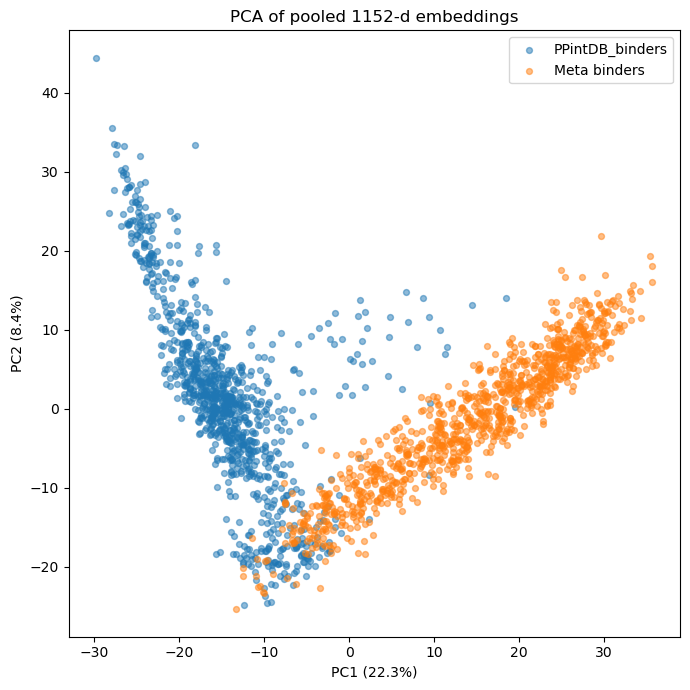

In [15]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB_binders       = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)        # (N1, 1152)
pooled_meta_binders  = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)    # (N2, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([pooled_PPintDB_binders, pooled_meta_binders])
X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

# 4) Split back by counts
N1 = pooled_PPintDB_binders.shape[0]
N2 = pooled_meta_binders.shape[0]

Z_PPintDB_binders = Z_all[:N1]
Z_meta_binders = Z_all[N1:]

# 5) Plot
plt.figure(figsize=(7,7))
plt.scatter(Z_PPintDB_binders[:,0], Z_PPintDB_binders[:,1], s=18, alpha=0.5, label="PPintDB_binders",  marker='o')
plt.scatter(Z_meta_binders[:,0], Z_meta_binders[:,1], s=18, alpha=0.5, label="Meta binders", marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
pca.explained_variance_ratio_

array([0.22277862, 0.08425952], dtype=float32)